In [29]:
from statsmodels.stats.multicomp import pairwise_tukeyhsd
import pandas as pd
import scipy.stats as stats
import seaborn as sns
import matplotlib.pyplot as plt

In [30]:
# read the data
inter = pd.read_csv("reliable_data.csv")

Null hypothesis: Non Stationarity exists in the series.

Alternative Hypothesis: Stationarity exists in the series

accepted_keys = where the null hypothesis was accepted 

rejected_keys = where the null hypothesis was rejected 

In [31]:
# Importing the necessary module
from statsmodels.tsa.stattools import adfuller

# Initializing dictionaries and lists to store results
results_dict = {}
accepted_pvalue_keys = []
rejected_pvalue_keys = []
accepted_critical_keys = []
rejected_critical_keys = []

# Function to perform ADF (Augmented Dickey-Fuller) test on a time series and store results
def adf_test(series, key_name):
    # Perform ADF test on the given time series
    result = adfuller(series)
    
    # Store results in a dictionary
    results_dict[key_name] = {
        'Test Statistic': result[0],
        'p-value': result[1],
        'Critical Values': {key: value for key, value in result[4].items()}
    }
    
    # Check if the p-value is less than 0.05 (common significance level)
    if result[1] < 0.05:
        rejected_pvalue_keys.append(key_name)
    else:
        accepted_pvalue_keys.append(key_name)
    
    # Check if the test statistic is greater than critical values (non-stationary if true)
    test_statistic = result[0]
    critical_values = result[4]
    
    if all(test_statistic < crit_value for crit_value in critical_values.values()):
        rejected_critical_keys.append(key_name)
    else:
        accepted_critical_keys.append(key_name)

# Loop through unique values in the 'main_key' column of the 'inter' DataFrame
for key in inter['main_key'].unique():
    # Select the subset of the DataFrame for the current 'main_key'
    series_key = inter[inter['main_key'] == key]['loss_percentage']
    
    # Call the ADF test function for the current subset
    adf_test(series_key, key)


/home/taps/anaconda3/lib/python3.10/site-packages/statsmodels/regression/linear_model.py:940: RuntimeWarning: divide by zero encountered in log
  llf = -nobs2*np.log(2*np.pi) - nobs2*np.log(ssr / nobs) - nobs2


Ho(Accepted): There is no trend present in the data.(p-value>0.05)

Ha(Rejected): A trend is present in the data.

In [7]:
# Importing the necessary module
import pymannkendall as mk

# Initializing dictionaries and lists to store results for trend analysis
results_dict_trend = {}
accepted_pvalue_keys_trend = []
rejected_pvalue_keys_trend = []

# Function to perform Mann-Kendall trend test on a time series and store results
def mann_kendall(series, key_name):
    # Perform Mann-Kendall trend test on the given time series
    result = mk.original_test(series)
    
    # Store results in a dictionary
    results_dict_trend[key_name] = {
        'Trend': result[0],
        'p-value': result[2]
    }
    
    # Check if the p-value is less than 0.05 (common significance level)
    if result[2] < 0.05:
        rejected_pvalue_keys_trend.append(key_name)
    else:
        accepted_pvalue_keys_trend.append(key_name)

# Loop through unique values in the 'main_key' column of the 'inter' DataFrame
for key in inter['main_key'].unique():
    # Select the subset of the DataFrame for the current 'main_key'
    series_key = inter[inter['main_key'] == key]['loss_percentage']
    
    # Call the Mann-Kendall trend test function for the current subset
    mann_kendall(series_key, key)


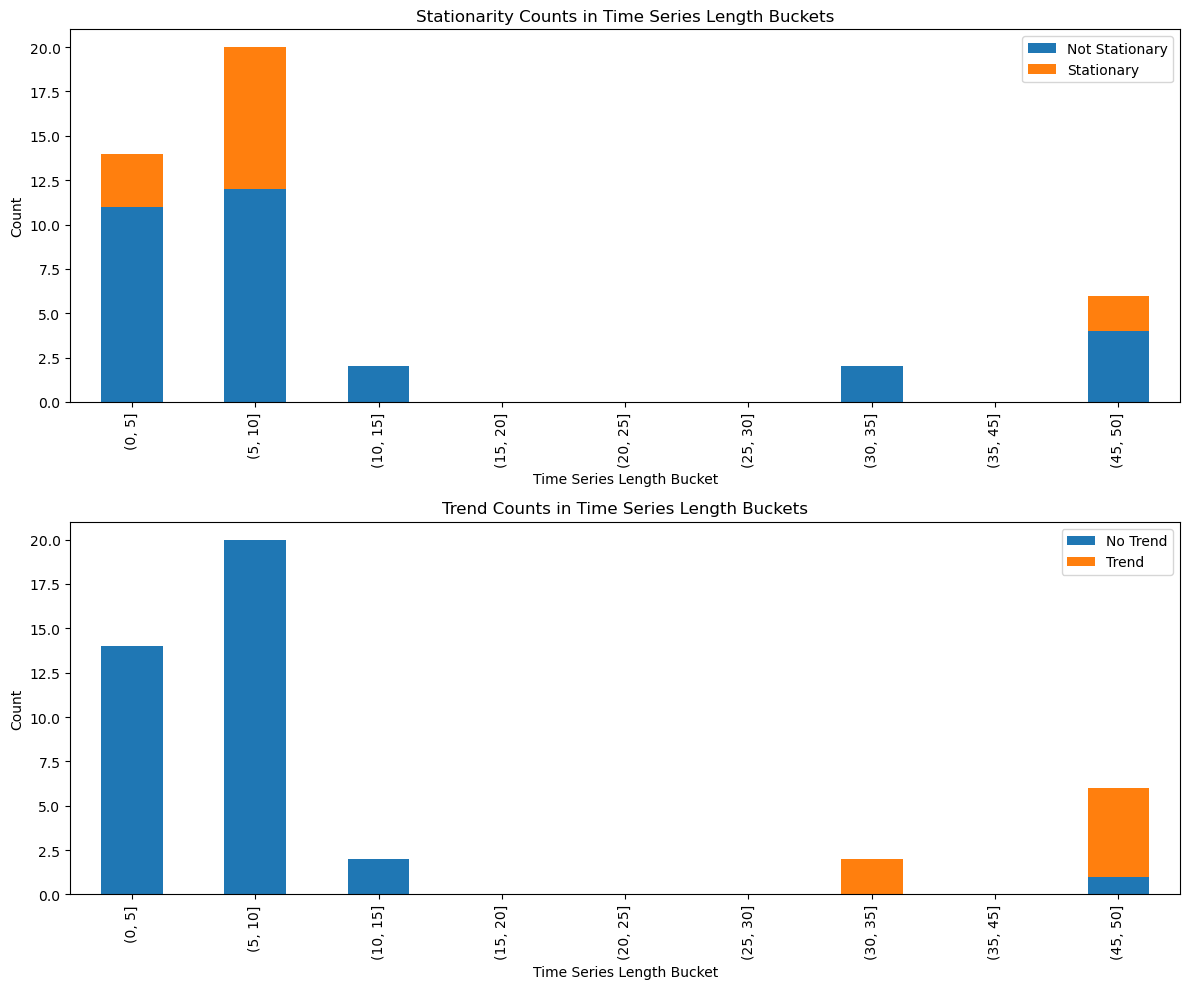

<Figure size 640x480 with 0 Axes>

In [52]:
import matplotlib.pyplot as plt
import pandas as pd

# Create a DataFrame to store the results
results_df = pd.DataFrame({
    'Key': list(results_dict.keys()),
    'TimeSeriesLength': [len(inter[inter['main_key'] == key]) for key in results_dict.keys()],
    'IsStationary': [key in rejected_pvalue_keys for key in results_dict.keys()],
    'HasTrend': [key in rejected_pvalue_keys_trend for key in results_dict.keys()]
})

# Define bins for time series length
bins = [0, 5, 10, 15, 20, 25, 30, 35, 45, 50]

# Create a new column 'LengthBucket' based on the bins
results_df['LengthBucket'] = pd.cut(results_df['TimeSeriesLength'], bins=bins)

# Group the DataFrame by 'LengthBucket' and 'IsStationary', count occurrences, and reshape the result
stationary_counts = results_df.groupby(['LengthBucket', 'IsStationary']).size().unstack(fill_value=0)

# Group the DataFrame by 'LengthBucket' and 'HasTrend', count occurrences, and reshape the result
trend_counts = results_df.groupby(['LengthBucket', 'HasTrend']).size().unstack(fill_value=0)

# Create subplots
fig, axes = plt.subplots(nrows=2, ncols=1, figsize=(12, 10))

# Plot the stacked bar chart for stationary counts
stationary_counts.plot(kind='bar', stacked=True, ax=axes[0])
axes[0].set_title('Stationarity Counts in Time Series Length Buckets')
axes[0].set_xlabel('Time Series Length Bucket')
axes[0].set_ylabel('Count')
axes[0].legend(['Not Stationary', 'Stationary'])

# Plot the stacked bar chart for trend counts
trend_counts.plot(kind='bar', stacked=True, ax=axes[1])
axes[1].set_title('Trend Counts in Time Series Length Buckets')
axes[1].set_xlabel('Time Series Length Bucket')
axes[1].set_ylabel('Count')
axes[1].legend(['No Trend', 'Trend'])

plt.tight_layout()

# Show the plot
plt.show()

# Save the plot as an image file
plt.savefig('foo.png', dpi=100)
